# Introduction to Diffusion MRI data

## Diffusion Weighted Imaging (DWI)

Diffusion imaging probes the random, microscopic motion of water protons by employing MRI sequences which are sensitive to the geometry and environmental organization surrounding the water protons. This is a popular technique for studying the white matter of the brain. The diffusion within biological structures, such as the brain, are often restricted due to barriers (eg. cell membranes), resulting in a preferred direction of diffusion (anisotropy). A typical diffusion MRI scan will acquire multiple volumes that are sensitive to a particular diffusion direction and result in diffusion-weighted images (DWI). Diffusion that exhibits directionality in the same direction result in an attenuated signal. With further processing (to be discussed later in the lesson), the acquired images can provide measurements which are related to the microscopic changes and estimate white matter trajectories. Images with no diffusion weighting are also acquired as part of the acquisition protocol.

![fiber_configurations](DiffusionDirections.png) \
Diffusion along X, Y, and Z directions

## b-values & b-vectors

In addition to the acquired diffusion images, two files are collected as part of the diffusion dataset. These files correspond to the gradient amplitude (b-values) and directions (b-vectors) of the diffusion measurement and are named with the extensions `.bval` and `.bvec` respectively. The b-value is the diffusion-sensitizing factor, and reflects the timing & strength of the gradients used to acquire the diffusion-weighted images. The b-vector corresponds to the direction of the diffusion sensitivity. Together these two files define the diffusion MRI measurement as a set of gradient directions and corresponding amplitudes.

## Dataset

For the rest of this tutorial, we will make use of a subset of publicly available dataset, ds000030, from [openneuro.org](https://openneuro.org/datasets/ds000030) The dataset is structured according to the Brain Imaging Data Structure ([BIDS](https://bids-specification.readthedocs.io/en/etable/)). 

Below is a tree diagram showing the folder structure of a single MR session within ds000030. This was obtained by using the bash command `tree`.  
`!tree ../data/ds000030`

```
ds000030
├── CHANGES
├── code
├── dataset_description.json
├── README
└── sub-10788/
    ├── anat
    │   ├── sub-10788_T1w.json
    │   └── sub-10788_T1w.nii.gz
    └── dwi
        ├── sub-10788_dwi.bval
        │── sub-10788_dwi.bvec
        │── sub-10788_dwi.json
        └── sub-10788_dwi.nii.gz
```

In [5]:
!aws s3 sync --no-sign-request \
  s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/sub-10788 \
  ../../data/ds000030/sub-10788 \
  --exclude '*' \
  --include '*T1w*' \
  --include '*dwi*'

## Querying a BIDS Dataset

[`pybids`](https://bids-standard.github.io/pybids/) is a Python API for querying, summarizing and manipulating the BIDS folder structure. We will make use of `pybids` to query the necessary files. 

Lets first pull the metadata from its associated JSON file using the `get_metadata()` function for the first run.

In [6]:
from bids.layout import BIDSLayout

layout = BIDSLayout("../../data/ds000030", validate=False)

In [7]:
dwi = layout.get(subject='10788', suffix='dwi', extension='nii.gz', return_type='file')[0]
layout.get_metadata(dwi)

{'AccelerationFactorPE': 1,
 'AcquisitionMatrix': '96/0/0/96',
 'DeviceSerialNumber': '35343',
 'EPIFactor': 128,
 'EchoTime': 0.0926,
 'EchoTrainLength': 1,
 'EffectiveEchoSpacing': 0.000689983,
 'FlipAngle': 90,
 'ImageType': 'ORIGINAL/PRIMARY/M/ND/MOSAIC',
 'ImagingFrequency': 123227595,
 'InPlanePhaseEncodingDirection': 'COL',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 3,
 'ManufacturerModelName': 'TrioTim',
 'NumberOfAverages': 1,
 'NumberOfPhaseEncodingSteps': 72,
 'PatientPosition': 'HFS',
 'PercentPhaseFieldOfView': 100,
 'PercentSampling': 100,
 'PhaseEncodingDirection': 'j-',
 'PixelBandwidth': 2265,
 'ProtocolName': 'DTI 64dir',
 'ReceiveCoilName': 'HeadMatrix',
 'RepetitionTime': 8.4,
 'ScanOptions': 'PFP/FS',
 'ScanningSequence': 'EP',
 'SequenceName': '*ep_b1000#10',
 'SequenceVariant': 'SK/SP',
 'SliceTiming': [4.2175,
  0,
  4.3575,
  0.14,
  4.4975,
  0.28,
  4.6375,
  0.4225,
  4.7775,
  0.5625,
  4.92,
  0.7025,
  5.06,
  0.8425,
  5.2,
  0.985,
  5.34,
  

## [`dipy`](http://dipy.org)

For this lesson, we will use the `Dipy` (Diffusion Imaging in Python) package for processing and analysing diffusion MRI.

### Why `dipy`? 

- Fully free and open source
- Implemented in Python. Easy to understand, and easy to use.
- Implementations of many state-of-the art algorithms
- High performance. Many algorithms implemented in [`cython`](http://cython.org/)

### Installing `dipy`

The easiest way to install `Dipy` is to use `pip`! Additionally, `Dipy` makes use of the FURY library for visualization. We will also install this using `pip`!

We can install it by entering the following in a terminal `pip install dipy`. We will do so using Jupyter Magic in the following cell!

### Defining a measurement: `GradientTable`

`Dipy` has a built-in function that allows us to read in `bval` and `bvec` files named `read_bvals_bvecs` under the `dipy.io.gradients` module. Let's first grab the path to our gradient directions and amplitude files and load them into memory.

In [8]:
dwi = layout.get(subject='10788', suffix='dwi', extension='.nii.gz', return_type='file')[0]
bvec = layout.get(subject='10788', suffix='dwi', extension='bvec', return_type='file')[0]
bval = layout.get(subject='10788', suffix='dwi', extension='bval', return_type='file')[0]

In [9]:
import numpy as np
import nibabel as nib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [16]:
data = nib.load(dwi).get_fdata()

In [18]:
data.shape

(96, 96, 60, 65)

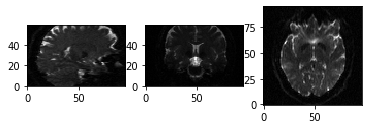

In [22]:
x_slice = data[58, :, :, 0]
y_slice = data[:, 58, :, 0]
z_slice = data[:, :, 30, 0]

slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

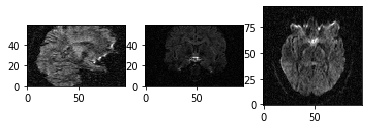

In [24]:
x_slice = data[58, :, :, 2]
y_slice = data[:, 58, :, 2]
z_slice = data[:, :, 30, 2]

slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

<function matplotlib.pyplot.show(*args, **kw)>

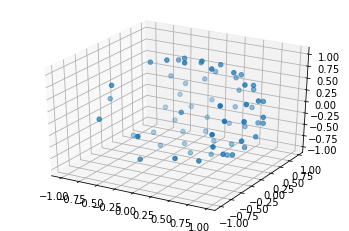

In [25]:
bvec_txt = np.genfromtxt(bvec)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bvec_txt[0], bvec_txt[1], bvec_txt[2])

plt.show

In [26]:
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

gt_bvals, gt_bvecs = read_bvals_bvecs(bval, bvec)

There is a also simple `GradientTable` object implemented in the `dipy.core.gradients` module. The input to the `GradientTable` should be our the values for our gradient directions and amplitudes we just read.

In [27]:
gtab = gradient_table(gt_bvals, gt_bvecs)

We will need this gradient table later on to process our data and generate diffusion tensor images (DTI)! 

There is also a built in function for gradient tables, `b0s_mask` that can be used to separate diffusion weighted measurements from non-diffusion weighted measurements (b=0s/mm^2). Try to extract the vector corresponding to diffusion weighted measurements in the following cell!

In [28]:
gtab.bvecs[~gtab.b0s_mask]

array([[-9.99984e-01,  4.03613e-03,  4.03613e-03],
       [-9.92980e-04, -9.99987e-01,  4.98886e-03],
       [-2.48897e-02,  6.53243e-01, -7.56739e-01],
       [-5.89518e-01,  7.69236e-01,  2.46462e-01],
       [ 2.35626e-01,  5.28739e-01,  8.15423e-01],
       [ 8.93067e-01,  2.63666e-01,  3.64570e-01],
       [ 7.97398e-01,  1.33552e-01, -5.88489e-01],
       [ 2.32919e-01,  9.31812e-01, -2.78344e-01],
       [ 9.36380e-01,  1.44036e-01, -3.20072e-01],
       [-5.04032e-01,  8.46814e-01, -1.69873e-01],
       [-3.44841e-01,  8.50410e-01, -3.97351e-01],
       [-4.55850e-01,  6.35469e-01, -6.23202e-01],
       [ 4.87386e-01,  3.93024e-01,  7.79735e-01],
       [-6.16792e-01,  6.76545e-01, -4.02310e-01],
       [ 5.77851e-01,  1.09487e-01, -8.08765e-01],
       [ 8.25555e-01,  5.24662e-01,  2.07818e-01],
       [ 8.94898e-01, -4.48150e-02,  4.44016e-01],
       [-2.89332e-01,  5.45724e-01, -7.86430e-01],
       [-1.15014e-01,  9.64050e-01, -2.39541e-01],
       [ 8.00058e-01, -4.08056e

It is also important to know where our diffusion weighting free measurements are as we need them for registration in our preprocessing, (our next notebook). The gtab.b0s_mask shows that this is our first volume of our dataset.

In [29]:
gtab.b0s_mask

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [30]:
b0 = data[:, :, :, gtab.b0s_mask]

In [31]:
b0.shape

(96, 96, 60, 1)

In [37]:
b0 = np.squeeze(b0)

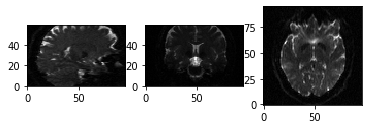

In [38]:
x_slice = b0[58, :, :]
y_slice = b0[:, 58, :]
z_slice = b0[:, :, 30]

slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

In the next few notebooks, we will talk more about preprocessing the diffusion weighted images and reconstructing the Tensor model